### Name     : Varunkumar Sonawane
### Roll no.  : 73
### Batch     : BE IT B4
### College  : RMDSSOE
### PNR        : 72036008M

#### 4. Use Autoencoder to implement anomaly detection. Build the model by using:
#### a. Import required libraries
#### b. Upload / access the dataset
#### c. Encoder converts it into latent representation
#### d. Decoder networks convert it back to the original input
#### e. Compile the models with Optimizer, Loss, and Evaluation Metrics

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score

RANDOM_SEED = 2021
TEST_PCT = 0.3
LABELS = ["Normal","Fraud"]

In [2]:
dataset = pd.read_csv("creditcard.csv")

In [3]:
dataset.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
#check for any null values
print("Any nulls in the dataset",dataset.isnull().values.any())
print('-------')
print("No. of unique labels",len(dataset['Class'].unique()))
print("Label values",dataset.Class.unique())

#0 is for normal credit card transcation
#1 is for fraudulent credit card transcation
print('-------')
print("Break down of Normal and Fraud Transcations")
print(pd.value_counts(dataset['Class'],sort=True))

Any nulls in the dataset False
-------
No. of unique labels 2
Label values [0 1]
-------
Break down of Normal and Fraud Transcations
0    284315
1       492
Name: Class, dtype: int64


Text(0, 0.5, 'Number of Observations')

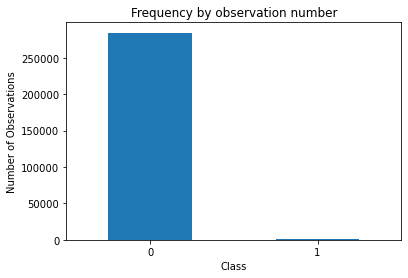

In [5]:
#visualizing the imbalanced dataset
count_classes = pd.value_counts(dataset['Class'],sort=True)
count_classes.plot(kind='bar',rot=0)
plt.xticks(range(len(dataset['Class'].unique())),dataset.Class.unique())
plt.title("Frequency by observation number")
plt.xlabel("Class")
plt.ylabel("Number of Observations")

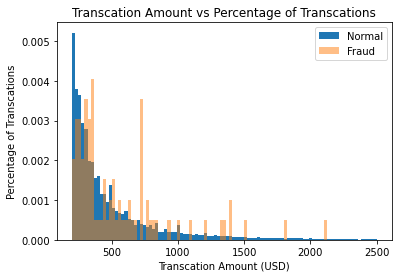

In [6]:
#Save the normal and fradulent transcations in seperate dataframe
normal_dataset = dataset[dataset.Class == 0]
fraud_dataset = dataset[dataset.Class == 1]

#Visualize transcation amounts for normal and fraudulent transcations
bins = np.linspace(200,2500,100)
plt.hist(normal_dataset.Amount,bins=bins,alpha=1,density=True,label='Normal')
plt.hist(fraud_dataset.Amount,bins=bins,alpha=0.5,density=True,label='Fraud')
plt.legend(loc='upper right')
plt.title("Transcation Amount vs Percentage of Transcations")
plt.xlabel("Transcation Amount (USD)")
plt.ylabel("Percentage of Transcations")
plt.show()

In [7]:
dataset

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [8]:
sc = StandardScaler()
dataset['Time'] = sc.fit_transform(dataset['Time'].values.reshape(-1,1))
dataset['Amount'] = sc.fit_transform(dataset['Amount'].values.reshape(-1,1))

In [9]:
raw_data = dataset.values
#The last element contains if the transcation is normal which is represented by 0 and if fraud then 1
labels = raw_data[:,-1]

#The other data points are the electrocadriogram data
data = raw_data[:,0:-1]

train_data,test_data,train_labels,test_labels = train_test_split(data,labels,test_size = 0.2,random_state =2021)

In [10]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data,tf.float32)
test_data = tf.cast(test_data,tf.float32)

In [11]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

#Creating normal and fraud datasets
normal_train_data = train_data[~train_labels]
normal_test_data = test_data[~test_labels]

fraud_train_data = train_data[train_labels]
fraud_test_data = test_data[test_labels]
print("No. of records in Fraud Train Data=",len(fraud_train_data))
print("No. of records in Normal Train Data=",len(normal_train_data))
print("No. of records in Fraud Test Data=",len(fraud_test_data))
print("No. of records in Normal Test Data=",len(normal_test_data))

No. of records in Fraud Train Data= 389
No. of records in Normal Train Data= 227456
No. of records in Fraud Test Data= 103
No. of records in Normal Test Data= 56859


In [12]:
nb_epoch = 50
batch_size = 64
input_dim = normal_train_data.shape[1]
#num of columns,30
encoding_dim = 14
hidden_dim1 = int(encoding_dim / 2)
hidden_dim2 = 4
learning_rate = 1e-7

In [13]:
#input layer
input_layer = tf.keras.layers.Input(shape=(input_dim,))

#Encoder
encoder = tf.keras.layers.Dense(encoding_dim,activation="tanh",activity_regularizer = tf.keras.regularizers.l2(learning_rate))(input_layer)
encoder = tf.keras.layers.Dropout(0.2)(encoder)
encoder = tf.keras.layers.Dense(hidden_dim1,activation='relu')(encoder)
encoder = tf.keras.layers.Dense(hidden_dim2,activation=tf.nn.leaky_relu)(encoder)

#Decoder
decoder = tf.keras.layers.Dense(hidden_dim1,activation='relu')(encoder)
decoder = tf.keras.layers.Dropout(0.2)(decoder)
decoder = tf.keras.layers.Dense(encoding_dim,activation='relu')(decoder)
decoder = tf.keras.layers.Dense(input_dim,activation='tanh')(decoder)

#Autoencoder
autoencoder = tf.keras.Model(inputs = input_layer,outputs = decoder)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 dense (Dense)               (None, 14)                434       
                                                                 
 dropout (Dropout)           (None, 14)                0         
                                                                 
 dense_1 (Dense)             (None, 7)                 105       
                                                                 
 dense_2 (Dense)             (None, 4)                 32        
                                                                 
 dense_3 (Dense)             (None, 7)                 35        
                                                                 
 dropout_1 (Dropout)         (None, 7)                 0     

In [14]:
cp = tf.keras.callbacks.ModelCheckpoint(filepath="autoencoder_fraud.h5",mode='min',monitor='val_loss',verbose=2,save_best_only=True)
#Define our early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                min_delta=0.0001,
                patience=10,
                verbose=11,
                mode='min',
                restore_best_weights=True
)

In [15]:
autoencoder.compile(metrics=['accuracy'],loss= 'mean_squared_error',optimizer='adam')

In [16]:
history = autoencoder.fit(normal_train_data,normal_train_data,epochs = nb_epoch,
                         batch_size = batch_size,shuffle = True,
                         validation_data = (test_data,test_data),
                         verbose=1,
                         callbacks = [cp,early_stop]).history

Epoch 1/50
3520/3554 [============================>.] - ETA: 0s - loss: 0.0040 - accuracy: 0.0263
Epoch 1: val_loss improved from inf to 0.00002, saving model to autoencoder_fraud.h5
3554/3554 [==============================] - 5s 1ms/step - loss: 0.0040 - accuracy: 0.0264 - val_loss: 1.9955e-05 - val_accuracy: 0.0420
Epoch 2/50
3504/3554 [============================>.] - ETA: 0s - loss: 1.9361e-05 - accuracy: 0.0594
Epoch 2: val_loss did not improve from 0.00002
3554/3554 [==============================] - 4s 1ms/step - loss: 1.9379e-05 - accuracy: 0.0592 - val_loss: 1.9959e-05 - val_accuracy: 0.0111
Epoch 3/50
3536/3554 [============================>.] - ETA: 0s - loss: 1.9418e-05 - accuracy: 0.0621
Epoch 3: val_loss did not improve from 0.00002
3554/3554 [==============================] - 4s 1ms/step - loss: 1.9432e-05 - accuracy: 0.0620 - val_loss: 2.0246e-05 - val_accuracy: 0.0133
Epoch 4/50
3548/3554 [============================>.] - ETA: 0s - loss: 1.9514e-05 - accuracy: 0.059

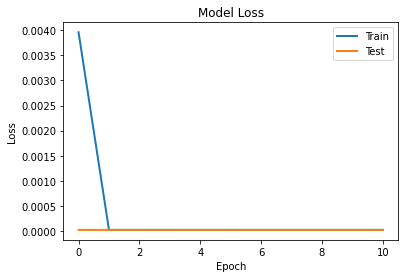

In [17]:
plt.plot(history['loss'],linewidth = 2,label = 'Train')
plt.plot(history['val_loss'],linewidth = 2,label = 'Test')
plt.legend(loc='upper right')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

#plt.ylim(ymin=0.70,ymax=1)

plt.show()

In [18]:
test_x_predictions = autoencoder.predict(test_data)
mse = np.mean(np.power(test_data - test_x_predictions, 2),axis = 1)
error_df = pd.DataFrame({'Reconstruction_error':mse,
                         'True_class':test_labels})

1781/1781 [==============================] - 1s 648us/step


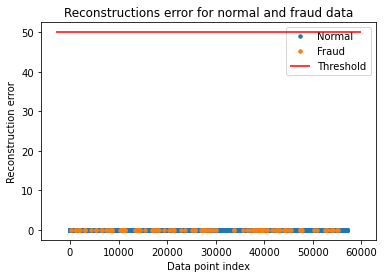

In [19]:
threshold_fixed = 50
groups = error_df.groupby('True_class')
fig,ax = plt.subplots()

for name,group in groups:
        ax.plot(group.index,group.Reconstruction_error,marker='o',ms = 3.5,linestyle='',
                label = "Fraud" if  name==1 else "Normal")
ax.hlines(threshold_fixed,ax.get_xlim()[0],ax.get_xlim()[1],colors="r",zorder=100,label="Threshold")
ax.legend()
plt.title("Reconstructions error for normal and fraud data")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

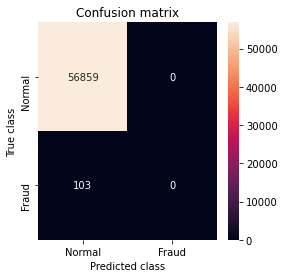

Accuracy : 0.9981917769741231
Recall : 0.0
Precision : 0.0


C:\Users\Varun Sonawane\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
threshold_fixed = 52
pred_y = [1 if e > threshold_fixed else 0 
          for e in 
        error_df.Reconstruction_error.values]
error_df['pred'] = pred_y
conf_matrix = confusion_matrix(error_df.True_class,pred_y)

plt.figure(figsize = (4,4))
sns.heatmap(conf_matrix,xticklabels = LABELS,yticklabels = LABELS,annot = True,fmt="d")
plt.title("Confusion matrix")
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.show()

#Print Accuracy,Precision and Recall
print("Accuracy :",accuracy_score(error_df['True_class'],error_df['pred']))
print("Recall :",recall_score(error_df['True_class'],error_df['pred']))
print("Precision :",precision_score(error_df['True_class'],error_df['pred']))